![title](dcgan.png)

In [1]:
%matplotlib inline
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DCGAN:
    def __init__(self, G_size, img_size, img_ch, shape_trace, kernel_size=(5, 5), strides=(2, 2)):
        self.G_size = G_size
        self.img_size = img_size
        self.img_ch = img_ch
        self.shape_trace = shape_trace
        self.kernel_size = kernel_size
        self.strides = strides
        self.build_graph()
    # end constructor


    def build_graph(self):
        self.add_input_layer()
        with tf.variable_scope('G'):
            self.add_Generator()
        with tf.variable_scope('D'):
            self.add_Discriminator()
        self.add_backward_path()
    # end method build_graph


    def add_input_layer(self):
        self.G_in = tf.placeholder(tf.float32, [None, self.G_size])
        self.X_in = tf.placeholder(tf.float32, [None, self.img_size[0], self.img_size[1], self.img_ch])
        self.train_flag = tf.placeholder(tf.bool)
    # end method input_layer


    def add_Generator(self):
        self.G_out = self.generate(self.G_in)
    # end method add_Generator


    def add_Discriminator(self):
        self.G_logits = self.discriminate(self.G_out)
        self.X_logits = self.discriminate(self.X_in, reuse=True)
        self.G_prob = tf.sigmoid(self.G_logits)
        self.X_prob = tf.sigmoid(self.X_logits)
    # end method add_Discriminator


    def add_backward_path(self):
        ones = tf.ones_like(self.G_logits)
        zeros = tf.zeros_like(self.G_logits)

        self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=ones, logits=self.G_logits))
        D_loss_X = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=ones, logits=self.X_logits))
        D_loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=zeros, logits=self.G_logits))
        self.D_loss = D_loss_X + D_loss_G

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='G')):
            self.G_train = tf.train.AdamOptimizer(2e-4, beta1=0.5).minimize(
                self.G_loss, var_list=tf.trainable_variables('G'))

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='D')):
            self.D_train = tf.train.AdamOptimizer(2e-4, beta1=0.5).minimize(
                self.D_loss, var_list=tf.trainable_variables('D'))

        self.mse = tf.reduce_mean(tf.squared_difference(self.G_out, self.X_in))
    # end method add_backward_path


    def generate(self, X):
        # for example: 100 -> (7, 7, 128) ->  (14, 14, 64) -> (28, 28, 1)
        nn = tf.layers.dense(X, np.prod(self.shape_trace[0]), self.lrelu)
        nn = tf.reshape(nn, [-1, self.shape_trace[0][0], self.shape_trace[0][1], self.shape_trace[0][2]])
        for s in self.shape_trace[1:]:
            nn = tf.layers.conv2d_transpose(nn, s[-1], self.kernel_size, strides=self.strides, padding='SAME')
            nn = tf.layers.batch_normalization(nn, training=self.train_flag, momentum=0.9)
            nn = self.lrelu(nn)
        nn = tf.layers.conv2d_transpose(nn, self.img_ch, self.kernel_size, strides=self.strides, padding='SAME')
        return tf.tanh(nn)
    # end method generate


    def discriminate(self, X, reuse=False):
        # for example: (28, 28, 1) -> (14, 14, 64) -> (7, 7, 128) -> 1
        nn = X
        for i, s in enumerate(list(reversed(self.shape_trace))):
            nn = tf.layers.conv2d(
                nn, s[2], self.kernel_size, strides=self.strides, padding='SAME', name='conv%d'%i, reuse=reuse)
            nn = tf.layers.batch_normalization(
                nn, training=self.train_flag, name='bn%d'%i, reuse=reuse, momentum=0.9)
            nn = self.lrelu(nn)
        flat = tf.reshape(nn, [-1, np.prod(self.shape_trace[0])])
        output = tf.layers.dense(flat, 1, name='out', reuse=reuse)
        return output
    # end method discriminate


    def lrelu(self, X, alpha=0.2):
        return tf.maximum(X, X * alpha)
    # end method lrelu
# end class

In [3]:
def gen_batch(arr, batch_size):
    for i in range(0, len(arr), batch_size):
        yield arr[i : i+batch_size]


def scaled(images):
    return (images.astype(np.float32) - (255./2)) / (255./2)


def select(images, labels, num):
    return np.expand_dims(images, 3)[labels == num]


def main(N_EPOCH, BATCH_SIZE, G_SIZE, DIGIT):    
    (X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
    X = select(scaled(X_train), y_train, DIGIT)
    
    gan = DCGAN(G_SIZE, (28, 28), 1, shape_trace=[(7, 7, 128), (14, 14, 64)])
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    for i, epoch in enumerate(range(N_EPOCH)):
        X = shuffle(X)
        for step, images in enumerate(gen_batch(X, BATCH_SIZE)):
            noise = np.random.randn(len(images), G_SIZE)

            sess.run(gan.D_train, {gan.G_in: noise,
                                   gan.X_in: images,
                                   gan.train_flag: True})
            for _ in range(2):
                sess.run(gan.G_train, {gan.G_in: noise,
                                       gan.train_flag: True})

            G_loss, D_loss, D_prob, G_prob, mse = sess.run([gan.G_loss,
                                                            gan.D_loss,
                                                            gan.X_prob,
                                                            gan.G_prob,
                                                            gan.mse],
                                                           {gan.G_in: noise,
                                                            gan.X_in: images,
                                                            gan.train_flag: False})
            
            print("Epoch %d/%d | Step %d/%d" % (epoch+1, N_EPOCH, step, len(X)//BATCH_SIZE))
            print("G loss: %.4f | D loss: %.4f | D prob: %.4f | G prob: %.4f | mse: %.4f" %
                 (G_loss, D_loss, D_prob.mean(), G_prob.mean(), mse))
    
    img = sess.run(gan.G_out, {gan.G_in: noise, gan.train_flag: False})[0]
    plt.imshow(np.squeeze(img))

Epoch 1/10 | Step 0/45
G loss: 0.7141 | D loss: 1.2995 | D prob: 0.5345 | G prob: 0.4897 | mse: 0.9169
Epoch 1/10 | Step 1/45
G loss: 0.7543 | D loss: 1.2603 | D prob: 0.5357 | G prob: 0.4703 | mse: 0.9167
Epoch 1/10 | Step 2/45
G loss: 0.8237 | D loss: 1.2198 | D prob: 0.5266 | G prob: 0.4388 | mse: 0.9109
Epoch 1/10 | Step 3/45
G loss: 0.9179 | D loss: 1.1773 | D prob: 0.5137 | G prob: 0.3994 | mse: 0.9055
Epoch 1/10 | Step 4/45
G loss: 1.0221 | D loss: 1.1557 | D prob: 0.4929 | G prob: 0.3598 | mse: 0.9053
Epoch 1/10 | Step 5/45
G loss: 1.1197 | D loss: 1.1031 | D prob: 0.4938 | G prob: 0.3264 | mse: 0.9034
Epoch 1/10 | Step 6/45
G loss: 1.2081 | D loss: 1.0764 | D prob: 0.4876 | G prob: 0.2988 | mse: 0.9040
Epoch 1/10 | Step 7/45
G loss: 1.3159 | D loss: 1.0308 | D prob: 0.4898 | G prob: 0.2683 | mse: 0.9033
Epoch 1/10 | Step 8/45
G loss: 1.4415 | D loss: 0.9647 | D prob: 0.5025 | G prob: 0.2366 | mse: 0.9043
Epoch 1/10 | Step 9/45
G loss: 1.5799 | D loss: 0.9232 | D prob: 0.5043 |

Epoch 2/10 | Step 33/45
G loss: 0.4209 | D loss: 1.8710 | D prob: 0.5155 | G prob: 0.6638 | mse: 0.4104
Epoch 2/10 | Step 34/45
G loss: 0.9045 | D loss: 2.1896 | D prob: 0.2317 | G prob: 0.4159 | mse: 0.4202
Epoch 2/10 | Step 35/45
G loss: 0.4412 | D loss: 1.8136 | D prob: 0.5141 | G prob: 0.6493 | mse: 0.4174
Epoch 2/10 | Step 36/45
G loss: 0.8481 | D loss: 2.1921 | D prob: 0.2393 | G prob: 0.4388 | mse: 0.4374
Epoch 2/10 | Step 37/45
G loss: 0.3732 | D loss: 1.8199 | D prob: 0.5933 | G prob: 0.6942 | mse: 0.4124
Epoch 2/10 | Step 38/45
G loss: 1.0878 | D loss: 2.2938 | D prob: 0.1786 | G prob: 0.3499 | mse: 0.4244
Epoch 2/10 | Step 39/45
G loss: 0.3110 | D loss: 1.9385 | D prob: 0.6112 | G prob: 0.7374 | mse: 0.4188
Epoch 2/10 | Step 40/45
G loss: 0.9938 | D loss: 2.3778 | D prob: 0.1782 | G prob: 0.3824 | mse: 0.4305
Epoch 2/10 | Step 41/45
G loss: 0.4980 | D loss: 1.9511 | D prob: 0.4276 | G prob: 0.6164 | mse: 0.4320
Epoch 2/10 | Step 42/45
G loss: 0.6642 | D loss: 1.9534 | D prob

Epoch 4/10 | Step 20/45
G loss: 1.4075 | D loss: 1.7861 | D prob: 0.2585 | G prob: 0.2664 | mse: 0.4378
Epoch 4/10 | Step 21/45
G loss: 0.3027 | D loss: 1.7236 | D prob: 0.7331 | G prob: 0.7428 | mse: 0.4555
Epoch 4/10 | Step 22/45
G loss: 1.1803 | D loss: 1.7761 | D prob: 0.2829 | G prob: 0.3255 | mse: 0.4313
Epoch 4/10 | Step 23/45
G loss: 0.4222 | D loss: 1.5507 | D prob: 0.6535 | G prob: 0.6608 | mse: 0.4341
Epoch 4/10 | Step 24/45
G loss: 0.8565 | D loss: 1.5871 | D prob: 0.3879 | G prob: 0.4365 | mse: 0.4471
Epoch 4/10 | Step 25/45
G loss: 0.6081 | D loss: 1.4723 | D prob: 0.5389 | G prob: 0.5524 | mse: 0.4297
Epoch 4/10 | Step 26/45
G loss: 0.7191 | D loss: 1.4599 | D prob: 0.4766 | G prob: 0.4939 | mse: 0.4343
Epoch 4/10 | Step 27/45
G loss: 0.7894 | D loss: 1.4998 | D prob: 0.4383 | G prob: 0.4638 | mse: 0.4174
Epoch 4/10 | Step 28/45
G loss: 0.6026 | D loss: 1.4734 | D prob: 0.5404 | G prob: 0.5557 | mse: 0.4332
Epoch 4/10 | Step 29/45
G loss: 0.9286 | D loss: 1.6280 | D prob

Epoch 6/10 | Step 7/45
G loss: 0.4809 | D loss: 1.3788 | D prob: 0.6951 | G prob: 0.6240 | mse: 0.4723
Epoch 6/10 | Step 8/45
G loss: 1.2347 | D loss: 1.4674 | D prob: 0.3461 | G prob: 0.3000 | mse: 0.4661
Epoch 6/10 | Step 9/45
G loss: 0.5121 | D loss: 1.3581 | D prob: 0.6681 | G prob: 0.6036 | mse: 0.4681
Epoch 6/10 | Step 10/45
G loss: 0.9737 | D loss: 1.3885 | D prob: 0.4250 | G prob: 0.3873 | mse: 0.4832
Epoch 6/10 | Step 11/45
G loss: 0.6845 | D loss: 1.2943 | D prob: 0.5901 | G prob: 0.5131 | mse: 0.4762
Epoch 6/10 | Step 12/45
G loss: 0.9112 | D loss: 1.2991 | D prob: 0.4836 | G prob: 0.4105 | mse: 0.4724
Epoch 6/10 | Step 13/45
G loss: 0.6800 | D loss: 1.2970 | D prob: 0.5880 | G prob: 0.5158 | mse: 0.4617
Epoch 6/10 | Step 14/45
G loss: 0.9343 | D loss: 1.3840 | D prob: 0.4434 | G prob: 0.4032 | mse: 0.4458
Epoch 6/10 | Step 15/45
G loss: 0.7663 | D loss: 1.3358 | D prob: 0.5195 | G prob: 0.4741 | mse: 0.4584
Epoch 6/10 | Step 16/45
G loss: 0.9106 | D loss: 1.3752 | D prob: 0

Epoch 7/10 | Step 40/45
G loss: 0.6119 | D loss: 1.3166 | D prob: 0.6213 | G prob: 0.5508 | mse: 0.4734
Epoch 7/10 | Step 41/45
G loss: 0.8448 | D loss: 1.2718 | D prob: 0.5172 | G prob: 0.4382 | mse: 0.4651
Epoch 7/10 | Step 42/45
G loss: 0.7948 | D loss: 1.2800 | D prob: 0.5321 | G prob: 0.4595 | mse: 0.4494
Epoch 7/10 | Step 43/45
G loss: 0.7962 | D loss: 1.2444 | D prob: 0.5491 | G prob: 0.4595 | mse: 0.4517
Epoch 7/10 | Step 44/45
G loss: 0.9619 | D loss: 1.2662 | D prob: 0.4770 | G prob: 0.3893 | mse: 0.4515
Epoch 7/10 | Step 45/45
G loss: 0.6905 | D loss: 1.2702 | D prob: 0.5891 | G prob: 0.5080 | mse: 0.4507
Epoch 8/10 | Step 0/45
G loss: 1.0392 | D loss: 1.3506 | D prob: 0.4250 | G prob: 0.3656 | mse: 0.4484
Epoch 8/10 | Step 1/45
G loss: 0.6308 | D loss: 1.2240 | D prob: 0.6523 | G prob: 0.5376 | mse: 0.4654
Epoch 8/10 | Step 2/45
G loss: 1.0460 | D loss: 1.2493 | D prob: 0.4683 | G prob: 0.3608 | mse: 0.4730
Epoch 8/10 | Step 3/45
G loss: 0.4947 | D loss: 1.3649 | D prob: 0.

Epoch 9/10 | Step 27/45
G loss: 1.0061 | D loss: 1.2909 | D prob: 0.4604 | G prob: 0.3768 | mse: 0.4535
Epoch 9/10 | Step 28/45
G loss: 0.6477 | D loss: 1.2236 | D prob: 0.6495 | G prob: 0.5329 | mse: 0.4699
Epoch 9/10 | Step 29/45
G loss: 0.8832 | D loss: 1.2694 | D prob: 0.5114 | G prob: 0.4247 | mse: 0.4677
Epoch 9/10 | Step 30/45
G loss: 0.8444 | D loss: 1.1902 | D prob: 0.5650 | G prob: 0.4403 | mse: 0.4540
Epoch 9/10 | Step 31/45
G loss: 0.6872 | D loss: 1.2638 | D prob: 0.5993 | G prob: 0.5104 | mse: 0.4444
Epoch 9/10 | Step 32/45
G loss: 0.8444 | D loss: 1.2930 | D prob: 0.5142 | G prob: 0.4401 | mse: 0.4703
Epoch 9/10 | Step 33/45
G loss: 0.7109 | D loss: 1.2337 | D prob: 0.6113 | G prob: 0.5015 | mse: 0.4701
Epoch 9/10 | Step 34/45
G loss: 0.9976 | D loss: 1.3396 | D prob: 0.4517 | G prob: 0.3800 | mse: 0.4589
Epoch 9/10 | Step 35/45
G loss: 0.5360 | D loss: 1.2908 | D prob: 0.7024 | G prob: 0.5935 | mse: 0.4468
Epoch 9/10 | Step 36/45
G loss: 1.4829 | D loss: 1.4823 | D prob

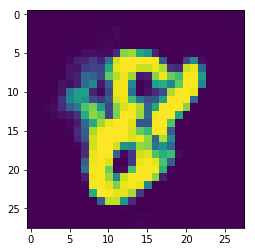

In [4]:
main(N_EPOCH = 10,
     BATCH_SIZE = 128,
     G_SIZE = 100,
     DIGIT = 8)